In [2]:
import tensorflow as tf

In [13]:
%matplotlib inline

from __future__ import division

import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np
scripts = os.path.join(os.path.dirname(os.getcwd()), "scripts")
sys.path.insert(0, scripts)
import math
import matplotlib.pyplot as plt

In [3]:
from data_utils import get_data

In [93]:
X_train, Y_train, X_val, Y_val = get_data()

print('Train data input shape: ', X_train.shape)
print('Train data output shape: ', Y_train.shape)
print('Validation data input shape: ', X_val.shape)
print('Validation data output  shape: ', Y_val.shape)


('Train data input shape: ', (180, 32, 32, 2))
('Train data output shape: ', (180, 32, 32))
('Validation data input shape: ', (20, 32, 32, 2))
('Validation data output  shape: ', (20, 32, 32))


In [5]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 2])
y = tf.placeholder(tf.float32, [None, 32, 32])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 2, 256])
    bconv1 = tf.get_variable("bconv1", shape=[256])
    W1 = tf.get_variable("W1", shape=[32,32,1,49])
    b1 = tf.get_variable("b1", shape=[32,32])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[32,32, 49, -1])
    y_out = tf.matmul(W1,h1_flat) #+ b1
    y_out = tf.transpose(y_out)
    y_out= tf.reshape(y_out, [-1,32,32])
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.nn.l2_loss(y - y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

Tensor("Relu:0", shape=(?, 14, 14, 256), dtype=float32)
Tensor("Reshape:0", shape=(32, 32, 49, ?), dtype=float32) <tf.Variable 'W1:0' shape=(32, 32, 1, 49) dtype=float32_ref>


In [7]:
mean_loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [22]:
X_val

array([[[[  -4.37207361,   -3.54066547],
         [  -4.98840772,   -4.03586696],
         [  -5.91609268,   -5.14090174],
         ..., 
         [ -13.99170922,  -11.33313417],
         [ -11.7765527 ,   -9.28916804],
         [  -9.24607137,   -7.46946298]],

        [[  -5.30251862,   -4.11057233],
         [  -5.93834683,   -5.36304261],
         [  -7.4467417 ,   -6.36395011],
         ..., 
         [ -17.56450357,  -14.08944303],
         [ -13.97703566,  -11.38163057],
         [ -11.31632447,   -8.89190889]],

        [[  -6.01832293,   -5.32423489],
         [  -7.30255177,   -6.25741621],
         [  -8.73606802,   -8.13312982],
         ..., 
         [ -21.54195594,  -17.23063889],
         [ -16.94462631,  -13.90699046],
         [ -13.22988024,  -10.68741283]],

        ..., 
        [[  -8.53522378,   -7.2323474 ],
         [ -10.61211424,   -9.40778056],
         [ -13.95679329,  -11.92160265],
         ..., 
         [ -14.58336564,  -12.71264855],
         [ -11.487

Training
Iteration 0: with minibatch training loss = 77637238784.0
Epoch 1, Overall loss = 1.81445351424e+11


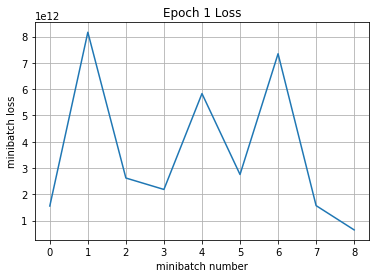

Iteration 10: with minibatch training loss = 4.0768782336e+11
Epoch 2, Overall loss = 1.81070136661e+11
Iteration 20: with minibatch training loss = 1.30079506432e+11
Epoch 3, Overall loss = 1.80368148252e+11
Iteration 30: with minibatch training loss = 1.07488346112e+11
Epoch 4, Overall loss = 1.79304752242e+11
Iteration 40: with minibatch training loss = 2.87305039872e+11
Epoch 5, Overall loss = 1.77946535026e+11
Iteration 50: with minibatch training loss = 1.32076453888e+11
Epoch 6, Overall loss = 1.76388066873e+11
Iteration 60: with minibatch training loss = 3.5552854016e+11
Epoch 7, Overall loss = 1.747172129e+11
Iteration 70: with minibatch training loss = 73812434944.0
Epoch 8, Overall loss = 1.73006531015e+11
Iteration 80: with minibatch training loss = 26665652224.0
Epoch 9, Overall loss = 1.71296410738e+11
Epoch 10, Overall loss = 1.69602747278e+11
Iteration 90: with minibatch training loss = 68997005312.0
Epoch 11, Overall loss = 1.67938310372e+11


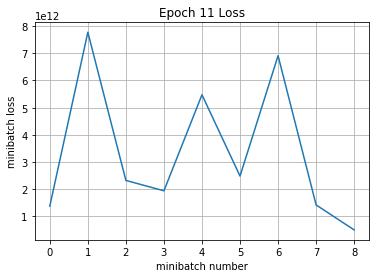

Iteration 100: with minibatch training loss = 3.8589333504e+11
Epoch 12, Overall loss = 1.66310978446e+11
Iteration 110: with minibatch training loss = 1.1282960384e+11
Epoch 13, Overall loss = 1.64737456356e+11
Iteration 120: with minibatch training loss = 92865585152.0
Epoch 14, Overall loss = 1.63233722368e+11
Iteration 130: with minibatch training loss = 2.66064297984e+11
Epoch 15, Overall loss = 1.6182487973e+11
Iteration 140: with minibatch training loss = 1.1756244992e+11
Epoch 16, Overall loss = 1.6051423323e+11
Iteration 150: with minibatch training loss = 3.32448792576e+11
Epoch 17, Overall loss = 1.59291009479e+11
Iteration 160: with minibatch training loss = 66079973376.0
Epoch 18, Overall loss = 1.58158676878e+11
Iteration 170: with minibatch training loss = 22991540224.0
Epoch 19, Overall loss = 1.57113657572e+11
Epoch 20, Overall loss = 1.56138120533e+11
Iteration 180: with minibatch training loss = 60847980544.0
Epoch 21, Overall loss = 1.55221597298e+11


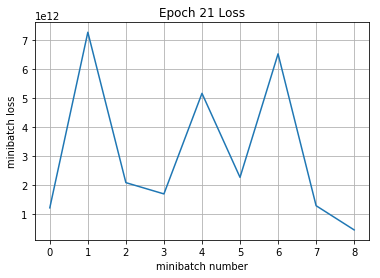

Iteration 190: with minibatch training loss = 3.60871755776e+11
Epoch 22, Overall loss = 1.54364569828e+11
Iteration 200: with minibatch training loss = 1.02939967488e+11
Epoch 23, Overall loss = 1.53568274887e+11
Iteration 210: with minibatch training loss = 82385977344.0
Epoch 24, Overall loss = 1.52819474204e+11
Iteration 220: with minibatch training loss = 2.53847207936e+11
Epoch 25, Overall loss = 1.52108431132e+11
Iteration 230: with minibatch training loss = 1.10311817216e+11
Epoch 26, Overall loss = 1.51450375054e+11
Iteration 240: with minibatch training loss = 3.17666885632e+11
Epoch 27, Overall loss = 1.50829818084e+11
Iteration 250: with minibatch training loss = 61786644480.0
Epoch 28, Overall loss = 1.50238363876e+11
Iteration 260: with minibatch training loss = 23116195840.0
Epoch 29, Overall loss = 1.49675628544e+11
Epoch 30, Overall loss = 1.49144969899e+11
Iteration 270: with minibatch training loss = 58250518528.0
Epoch 31, Overall loss = 1.48651196644e+11


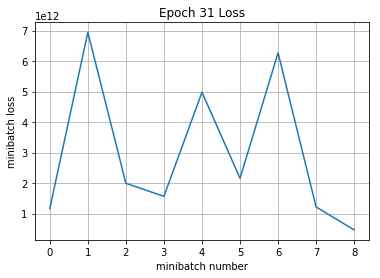

Iteration 280: with minibatch training loss = 3.46037256192e+11
Epoch 32, Overall loss = 1.48169111097e+11
Iteration 290: with minibatch training loss = 99120496640.0
Epoch 33, Overall loss = 1.47718536306e+11
Iteration 300: with minibatch training loss = 77061832704.0
Epoch 34, Overall loss = 1.47298316743e+11
Iteration 310: with minibatch training loss = 2.46251503616e+11
Epoch 35, Overall loss = 1.46907133269e+11
Iteration 320: with minibatch training loss = 1.05888178176e+11
Epoch 36, Overall loss = 1.46518366891e+11
Iteration 330: with minibatch training loss = 3.0847238144e+11
Epoch 37, Overall loss = 1.46109475499e+11
Iteration 340: with minibatch training loss = 59134824448.0
Epoch 38, Overall loss = 1.45733383964e+11
Iteration 350: with minibatch training loss = 23912656896.0
Epoch 39, Overall loss = 1.45382835996e+11
Epoch 40, Overall loss = 1.45043276459e+11
Iteration 360: with minibatch training loss = 57201401856.0
Epoch 41, Overall loss = 1.44697814812e+11


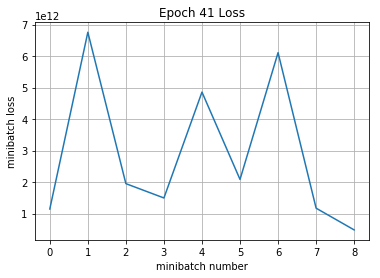

Iteration 370: with minibatch training loss = 3.37022713856e+11
Epoch 42, Overall loss = 1.4436008869e+11
Iteration 380: with minibatch training loss = 97134051328.0
Epoch 43, Overall loss = 1.44049874034e+11
Iteration 390: with minibatch training loss = 73919070208.0
Epoch 44, Overall loss = 1.43743198094e+11
Iteration 400: with minibatch training loss = 2.40669523968e+11
Epoch 45, Overall loss = 1.43431031467e+11
Iteration 410: with minibatch training loss = 1.02718472192e+11
Epoch 46, Overall loss = 1.43123268494e+11
Iteration 420: with minibatch training loss = 3.01725581312e+11
Epoch 47, Overall loss = 1.42817939001e+11
Iteration 430: with minibatch training loss = 57331523584.0
Epoch 48, Overall loss = 1.42512358286e+11
Iteration 440: with minibatch training loss = 24302469120.0
Epoch 49, Overall loss = 1.42223271708e+11
Epoch 50, Overall loss = 1.41952057344e+11
Iteration 450: with minibatch training loss = 56456712192.0
Epoch 51, Overall loss = 1.41689294393e+11


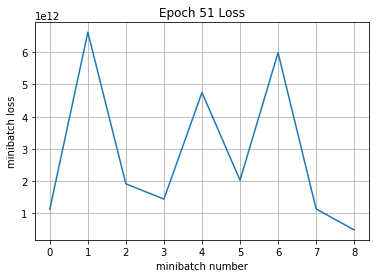

Iteration 460: with minibatch training loss = 3.30498801664e+11
Epoch 52, Overall loss = 1.41426390812e+11
Iteration 470: with minibatch training loss = 95519858688.0
Epoch 53, Overall loss = 1.41143776597e+11
Iteration 480: with minibatch training loss = 71512088576.0
Epoch 54, Overall loss = 1.40870465991e+11
Iteration 490: with minibatch training loss = 2.3568433152e+11
Epoch 55, Overall loss = 1.40613342094e+11
Iteration 500: with minibatch training loss = 1.00343799808e+11
Epoch 56, Overall loss = 1.40371188167e+11
Iteration 510: with minibatch training loss = 2.9647372288e+11
Epoch 57, Overall loss = 1.40139180487e+11
Iteration 520: with minibatch training loss = 55949713408.0
Epoch 58, Overall loss = 1.39912939292e+11
Iteration 530: with minibatch training loss = 24425848832.0
Epoch 59, Overall loss = 1.39677335552e+11
Epoch 60, Overall loss = 1.39447928604e+11
Iteration 540: with minibatch training loss = 55558512640.0
Epoch 61, Overall loss = 1.39244954738e+11


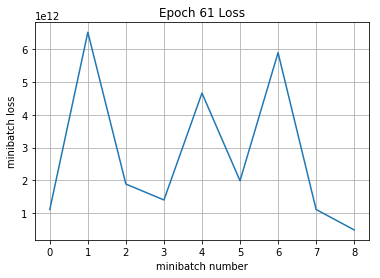

Iteration 550: with minibatch training loss = 3.2540721152e+11
Epoch 62, Overall loss = 1.3904556032e+11
Iteration 560: with minibatch training loss = 94087856128.0
Epoch 63, Overall loss = 1.38823615374e+11
Iteration 570: with minibatch training loss = 69521596416.0
Epoch 64, Overall loss = 1.38575249863e+11
Iteration 580: with minibatch training loss = 2.32055095296e+11
Epoch 65, Overall loss = 1.383346688e+11
Iteration 590: with minibatch training loss = 98431877120.0
Epoch 66, Overall loss = 1.38070130233e+11
Iteration 600: with minibatch training loss = 2.91627106304e+11
Epoch 67, Overall loss = 1.3782268746e+11
Iteration 610: with minibatch training loss = 54791753728.0
Epoch 68, Overall loss = 1.37600658318e+11
Iteration 620: with minibatch training loss = 24356188160.0
Epoch 69, Overall loss = 1.37377564444e+11
Epoch 70, Overall loss = 1.37157329351e+11
Iteration 630: with minibatch training loss = 54415876096.0
Epoch 71, Overall loss = 1.36939485867e+11


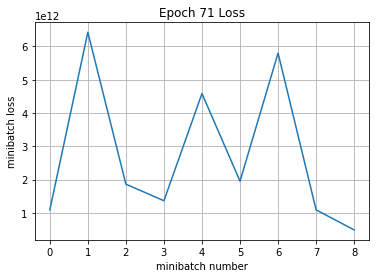

Iteration 640: with minibatch training loss = 3.20773947392e+11
Epoch 72, Overall loss = 1.36720167822e+11
Iteration 650: with minibatch training loss = 92823789568.0
Epoch 73, Overall loss = 1.3650134107e+11
Iteration 660: with minibatch training loss = 67676393472.0
Epoch 74, Overall loss = 1.36287512348e+11
Iteration 670: with minibatch training loss = 2.27737419776e+11
Epoch 75, Overall loss = 1.36085980046e+11
Iteration 680: with minibatch training loss = 96821813248.0
Epoch 76, Overall loss = 1.35885481301e+11
Iteration 690: with minibatch training loss = 2.87363825664e+11
Epoch 77, Overall loss = 1.35689427627e+11
Iteration 700: with minibatch training loss = 53747875840.0
Epoch 78, Overall loss = 1.35502692807e+11
Iteration 710: with minibatch training loss = 24414920704.0
Epoch 79, Overall loss = 1.35328217771e+11
Epoch 80, Overall loss = 1.35133663232e+11
Iteration 720: with minibatch training loss = 53543829504.0
Epoch 81, Overall loss = 1.34932198514e+11


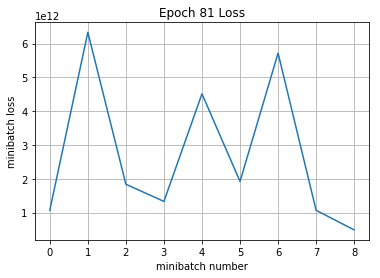

Iteration 730: with minibatch training loss = 3.16324020224e+11
Epoch 82, Overall loss = 1.34744338432e+11
Iteration 740: with minibatch training loss = 91792850944.0
Epoch 83, Overall loss = 1.34572924928e+11
Iteration 750: with minibatch training loss = 66078793728.0
Epoch 84, Overall loss = 1.34386739883e+11
Iteration 760: with minibatch training loss = 2.2446768128e+11
Epoch 85, Overall loss = 1.34205228373e+11
Iteration 770: with minibatch training loss = 95470796800.0
Epoch 86, Overall loss = 1.34024991175e+11
Iteration 780: with minibatch training loss = 2.8380086272e+11
Epoch 87, Overall loss = 1.3385830309e+11
Iteration 790: with minibatch training loss = 52848766976.0
Epoch 88, Overall loss = 1.33690841771e+11
Iteration 800: with minibatch training loss = 24504369152.0
Epoch 89, Overall loss = 1.33525266887e+11
Epoch 90, Overall loss = 1.33336242859e+11
Iteration 810: with minibatch training loss = 52542300160.0
Epoch 91, Overall loss = 1.33156608683e+11


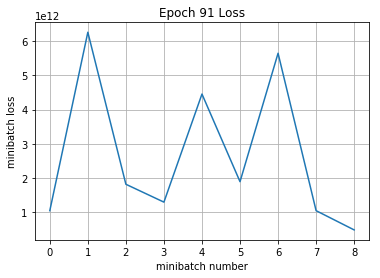

Iteration 820: with minibatch training loss = 3.1248121856e+11
Epoch 92, Overall loss = 1.33005020274e+11
Iteration 830: with minibatch training loss = 90976575488.0
Epoch 93, Overall loss = 1.3288449957e+11
Iteration 840: with minibatch training loss = 64686170112.0
Epoch 94, Overall loss = 1.32807133412e+11
Iteration 850: with minibatch training loss = 2.22062706688e+11
Epoch 95, Overall loss = 1.32761089593e+11
Iteration 860: with minibatch training loss = 94369734656.0
Epoch 96, Overall loss = 1.32614634382e+11
Iteration 870: with minibatch training loss = 2.80698748928e+11
Epoch 97, Overall loss = 1.32349493703e+11
Iteration 880: with minibatch training loss = 52039176192.0
Epoch 98, Overall loss = 1.32107318158e+11
Iteration 890: with minibatch training loss = 24636887040.0
Epoch 99, Overall loss = 1.319320576e+11
Epoch 100, Overall loss = 1.31796279979e+11
Iteration 900: with minibatch training loss = 51728809984.0
Epoch 101, Overall loss = 1.31686088932e+11


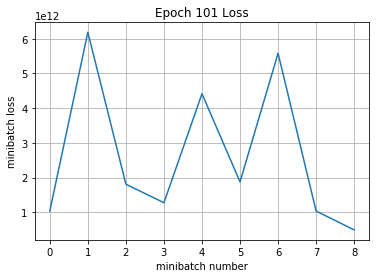

Iteration 910: with minibatch training loss = 3.08896858112e+11
Epoch 102, Overall loss = 1.31561622642e+11
Iteration 920: with minibatch training loss = 90358996992.0
Epoch 103, Overall loss = 1.31396281685e+11
Iteration 930: with minibatch training loss = 63397974016.0
Epoch 104, Overall loss = 1.31208826652e+11
Iteration 940: with minibatch training loss = 2.19154776064e+11
Epoch 105, Overall loss = 1.31050961579e+11
Iteration 950: with minibatch training loss = 93302448128.0
Epoch 106, Overall loss = 1.30903465074e+11
Iteration 960: with minibatch training loss = 2.7685322752e+11
Epoch 107, Overall loss = 1.30760678969e+11
Iteration 970: with minibatch training loss = 51294769152.0
Epoch 108, Overall loss = 1.30630691954e+11
Iteration 980: with minibatch training loss = 24821854208.0
Epoch 109, Overall loss = 1.30506675086e+11
Epoch 110, Overall loss = 1.30396783047e+11
Iteration 990: with minibatch training loss = 50995769344.0
Epoch 111, Overall loss = 1.30277167559e+11


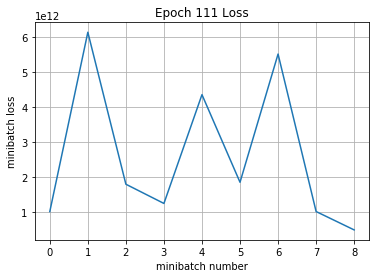

Iteration 1000: with minibatch training loss = 3.06188713984e+11
Epoch 112, Overall loss = 1.30126044501e+11
Iteration 1010: with minibatch training loss = 89918111744.0
Epoch 113, Overall loss = 1.29981907854e+11
Iteration 1020: with minibatch training loss = 62232141824.0
Epoch 114, Overall loss = 1.29826707684e+11
Iteration 1030: with minibatch training loss = 2.1688172544e+11
Epoch 115, Overall loss = 1.29665442247e+11
Iteration 1040: with minibatch training loss = 92341927936.0
Epoch 116, Overall loss = 1.29538583211e+11
Iteration 1050: with minibatch training loss = 2.73812717568e+11
Epoch 117, Overall loss = 1.29398383957e+11
Iteration 1060: with minibatch training loss = 50575413248.0
Epoch 118, Overall loss = 1.2926819146e+11
Iteration 1070: with minibatch training loss = 25050824704.0
Epoch 119, Overall loss = 1.2915286107e+11
Epoch 120, Overall loss = 1.2903358282e+11
Iteration 1080: with minibatch training loss = 50301984768.0
Epoch 121, Overall loss = 1.28924973739e+11


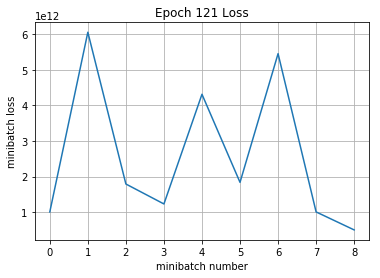

Iteration 1090: with minibatch training loss = 3.02623883264e+11
Epoch 122, Overall loss = 1.28827332608e+11
Iteration 1100: with minibatch training loss = 89565028352.0
Epoch 123, Overall loss = 1.28717072612e+11
Iteration 1110: with minibatch training loss = 61218672640.0
Epoch 124, Overall loss = 1.28600748487e+11
Iteration 1120: with minibatch training loss = 2.149646336e+11
Epoch 125, Overall loss = 1.28489624007e+11
Iteration 1130: with minibatch training loss = 91558928384.0
Epoch 126, Overall loss = 1.28411422037e+11
Iteration 1140: with minibatch training loss = 2.71779250176e+11
Epoch 127, Overall loss = 1.28301226894e+11
Iteration 1150: with minibatch training loss = 49943875584.0
Epoch 128, Overall loss = 1.28150149575e+11
Iteration 1160: with minibatch training loss = 25259597824.0
Epoch 129, Overall loss = 1.27997901483e+11
Epoch 130, Overall loss = 1.27873528263e+11
Iteration 1170: with minibatch training loss = 49690779648.0
Epoch 131, Overall loss = 1.27778767758e+11


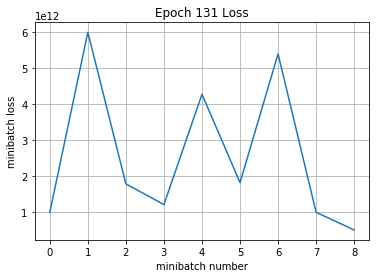

Iteration 1180: with minibatch training loss = 2.9997449216e+11
Epoch 132, Overall loss = 1.27700769451e+11
Iteration 1190: with minibatch training loss = 89276645376.0
Epoch 133, Overall loss = 1.27632713956e+11
Iteration 1200: with minibatch training loss = 60287299584.0
Epoch 134, Overall loss = 1.27593277668e+11
Iteration 1210: with minibatch training loss = 2.14021603328e+11
Epoch 135, Overall loss = 1.27582333156e+11
Iteration 1220: with minibatch training loss = 90822656000.0
Epoch 136, Overall loss = 1.27517548316e+11
Iteration 1230: with minibatch training loss = 2.6954858496e+11
Epoch 137, Overall loss = 1.27388754148e+11
Iteration 1240: with minibatch training loss = 49399373824.0
Epoch 138, Overall loss = 1.2730520394e+11
Iteration 1250: with minibatch training loss = 25453514752.0
Epoch 139, Overall loss = 1.27139106816e+11
Epoch 140, Overall loss = 1.26936713671e+11
Iteration 1260: with minibatch training loss = 49242857472.0
Epoch 141, Overall loss = 1.26801049828e+11


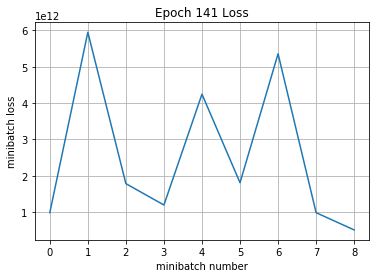

Iteration 1270: with minibatch training loss = 2.973253632e+11
Epoch 142, Overall loss = 1.26716729572e+11
Iteration 1280: with minibatch training loss = 89093144576.0
Epoch 143, Overall loss = 1.2663937957e+11
Iteration 1290: with minibatch training loss = 59542806528.0
Epoch 144, Overall loss = 1.26584098133e+11
Iteration 1300: with minibatch training loss = 2.13168750592e+11
Epoch 145, Overall loss = 1.26541632853e+11
Iteration 1310: with minibatch training loss = 90123321344.0
Epoch 146, Overall loss = 1.26435660914e+11
Iteration 1320: with minibatch training loss = 2.66074619904e+11
Epoch 147, Overall loss = 1.26299130994e+11
Iteration 1330: with minibatch training loss = 48838000640.0
Epoch 148, Overall loss = 1.26159085568e+11
Iteration 1340: with minibatch training loss = 25676234752.0
Epoch 149, Overall loss = 1.26035960718e+11
Epoch 150, Overall loss = 1.25941286684e+11
Iteration 1350: with minibatch training loss = 49328549888.0
Epoch 151, Overall loss = 1.25861625401e+11


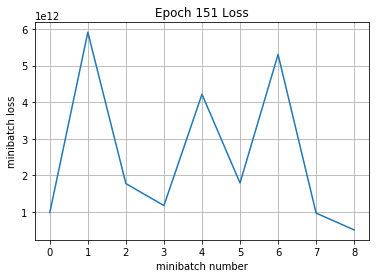

Iteration 1360: with minibatch training loss = 2.95268450304e+11
Epoch 152, Overall loss = 1.25780843634e+11
Iteration 1370: with minibatch training loss = 88896684032.0
Epoch 153, Overall loss = 1.25652944441e+11
Iteration 1380: with minibatch training loss = 58681184256.0
Epoch 154, Overall loss = 1.25511674994e+11
Iteration 1390: with minibatch training loss = 2.10266013696e+11
Epoch 155, Overall loss = 1.25425269874e+11
Iteration 1400: with minibatch training loss = 89473220608.0
Epoch 156, Overall loss = 1.25362664334e+11
Iteration 1410: with minibatch training loss = 2.6364592128e+11
Epoch 157, Overall loss = 1.252905183e+11
Iteration 1420: with minibatch training loss = 48263475200.0
Epoch 158, Overall loss = 1.25181887829e+11
Iteration 1430: with minibatch training loss = 25841090560.0
Epoch 159, Overall loss = 1.25067720021e+11
Epoch 160, Overall loss = 1.24956580978e+11
Iteration 1440: with minibatch training loss = 48313131008.0
Epoch 161, Overall loss = 1.24860278101e+11


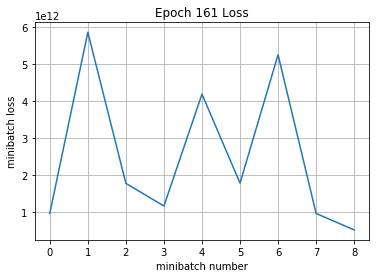

Iteration 1450: with minibatch training loss = 2.9280075776e+11
Epoch 162, Overall loss = 1.24758221028e+11
Iteration 1460: with minibatch training loss = 88732762112.0
Epoch 163, Overall loss = 1.2465709238e+11
Iteration 1470: with minibatch training loss = 57968967680.0
Epoch 164, Overall loss = 1.24567186546e+11
Iteration 1480: with minibatch training loss = 2.08997531648e+11
Epoch 165, Overall loss = 1.24486980949e+11
Iteration 1490: with minibatch training loss = 88845238272.0
Epoch 166, Overall loss = 1.2441034661e+11
Iteration 1500: with minibatch training loss = 2.61571903488e+11
Epoch 167, Overall loss = 1.2431681536e+11
Iteration 1510: with minibatch training loss = 47736709120.0
Epoch 168, Overall loss = 1.24222539093e+11
Iteration 1520: with minibatch training loss = 26016878592.0
Epoch 169, Overall loss = 1.24139064889e+11
Epoch 170, Overall loss = 1.24104954994e+11
Iteration 1530: with minibatch training loss = 48007651328.0
Epoch 171, Overall loss = 1.24079186375e+11


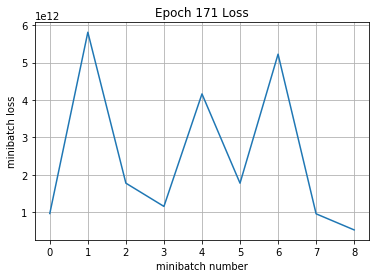

Iteration 1540: with minibatch training loss = 2.90514731008e+11
Epoch 172, Overall loss = 1.24010315093e+11
Iteration 1550: with minibatch training loss = 88666210304.0
Epoch 173, Overall loss = 1.23878206805e+11
Iteration 1560: with minibatch training loss = 57345232896.0
Epoch 174, Overall loss = 1.23765007474e+11
Iteration 1570: with minibatch training loss = 2.07769616384e+11
Epoch 175, Overall loss = 1.23692158521e+11
Iteration 1580: with minibatch training loss = 88276254720.0
Epoch 176, Overall loss = 1.23655536868e+11
Iteration 1590: with minibatch training loss = 2.5979469824e+11
Epoch 177, Overall loss = 1.2359264165e+11
Iteration 1600: with minibatch training loss = 47293042688.0
Epoch 178, Overall loss = 1.23494676252e+11
Iteration 1610: with minibatch training loss = 26190778368.0
Epoch 179, Overall loss = 1.23385117355e+11
Epoch 180, Overall loss = 1.23300923392e+11
Iteration 1620: with minibatch training loss = 47970209792.0
Epoch 181, Overall loss = 1.23274954524e+11


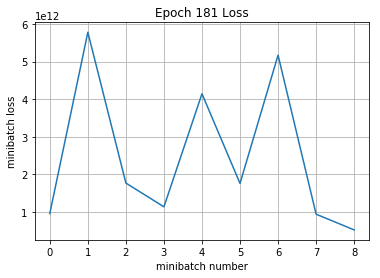

Iteration 1630: with minibatch training loss = 2.88860274688e+11
Epoch 182, Overall loss = 1.23311368192e+11
Iteration 1640: with minibatch training loss = 88501043200.0
Epoch 183, Overall loss = 1.23329728967e+11
Iteration 1650: with minibatch training loss = 56813305856.0
Epoch 184, Overall loss = 1.23277735708e+11
Iteration 1660: with minibatch training loss = 2.07548940288e+11
Epoch 185, Overall loss = 1.23204200676e+11
Iteration 1670: with minibatch training loss = 87829200896.0
Epoch 186, Overall loss = 1.23099004928e+11
Iteration 1680: with minibatch training loss = 2.58113437696e+11
Epoch 187, Overall loss = 1.22980327424e+11
Iteration 1690: with minibatch training loss = 46858395648.0
Epoch 188, Overall loss = 1.22909351708e+11
Iteration 1700: with minibatch training loss = 26309283840.0
Epoch 189, Overall loss = 1.22875513515e+11
Epoch 190, Overall loss = 1.22705599829e+11
Iteration 1710: with minibatch training loss = 47387942912.0
Epoch 191, Overall loss = 1.22556949845e+11

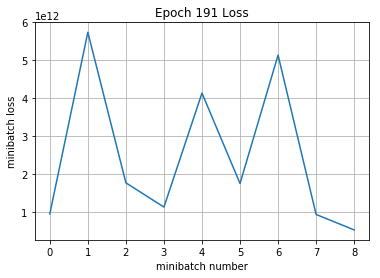

Iteration 1720: with minibatch training loss = 2.86662918144e+11
Epoch 192, Overall loss = 1.22534557924e+11
Iteration 1730: with minibatch training loss = 88381308928.0
Epoch 193, Overall loss = 1.22509480846e+11
Iteration 1740: with minibatch training loss = 56351698944.0
Epoch 194, Overall loss = 1.22374869902e+11
Iteration 1750: with minibatch training loss = 2.0560101376e+11
Epoch 195, Overall loss = 1.2224478299e+11
Iteration 1760: with minibatch training loss = 87227858944.0
Epoch 196, Overall loss = 1.22175061561e+11
Iteration 1770: with minibatch training loss = 2.55600771072e+11
Epoch 197, Overall loss = 1.22131732252e+11
Iteration 1780: with minibatch training loss = 46409318400.0
Epoch 198, Overall loss = 1.22114732487e+11
Iteration 1790: with minibatch training loss = 26532196352.0
Epoch 199, Overall loss = 1.22123014599e+11
Epoch 200, Overall loss = 1.2203447114e+11
Validation
Epoch 1, Overall loss = 1.23424915456e+11
0
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


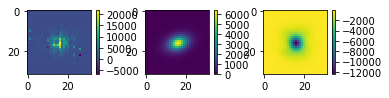

1
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


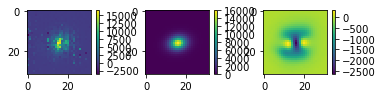

2
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


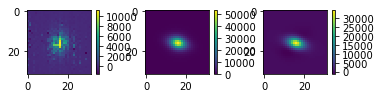

3
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


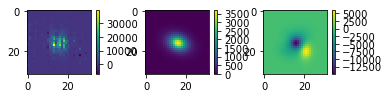

4
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


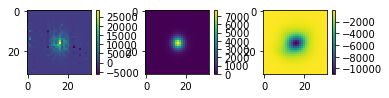

In [76]:
def run_model(session, predict, mean_loss, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    pred_loss = tf.reduce_mean((tf.nn.l2_loss(y - predict)))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, pred_loss,]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:, :, :],
                         y: yd[idx, :, :],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, im = session.run(variables,feed_dict=feed_dict)
            pred = y_out.eval(session=session, feed_dict=feed_dict)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1}"\
                      .format(iter_cnt,loss))
            iter_cnt += 1
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0}"\
              .format(total_loss, e+1))
        if plot_losses and (e % print_every) == 0:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
        if training_now is False:
            for num in range(5):
                print  num
                plt.subplot(3,3,1)
                print pred.shape, yd.shape
                plt.imshow(pred[num])
                plt.colorbar()
                plt.subplot(3,3,2)
                plt.imshow(yd[num])
                plt.colorbar()
                plt.subplot(3,3,3)
                print Xd.shape
                plt.imshow(Xd[num, :, :,0])
                plt.colorbar()
                plt.show()
    return total_loss

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,Y_train,200,20,10,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,Y_val,1,20)

Training
Iteration 0: with minibatch training loss = 1.9885391872e+11
Epoch 1, Overall loss = 1.81257036686e+11


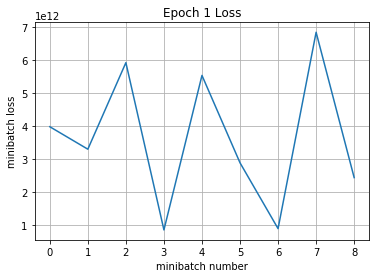

Iteration 10: with minibatch training loss = 1.6306536448e+11
Epoch 2, Overall loss = 1.79829035008e+11
Iteration 20: with minibatch training loss = 2.9328867328e+11
Epoch 3, Overall loss = 1.7750122314e+11
Iteration 30: with minibatch training loss = 39899348992.0
Epoch 4, Overall loss = 1.74759916885e+11
Iteration 40: with minibatch training loss = 2.60850941952e+11
Epoch 5, Overall loss = 1.7176258469e+11
Iteration 50: with minibatch training loss = 1.3173563392e+11
Epoch 6, Overall loss = 1.68781589163e+11
Iteration 60: with minibatch training loss = 35448909824.0
Epoch 7, Overall loss = 1.65859828167e+11
Iteration 70: with minibatch training loss = 3.22304802816e+11
Epoch 8, Overall loss = 1.63025820103e+11
Iteration 80: with minibatch training loss = 1.01566660608e+11
Epoch 9, Overall loss = 1.60355478414e+11
Epoch 10, Overall loss = 1.57907744996e+11
Iteration 90: with minibatch training loss = 1.71479105536e+11
Epoch 11, Overall loss = 1.55695732964e+11


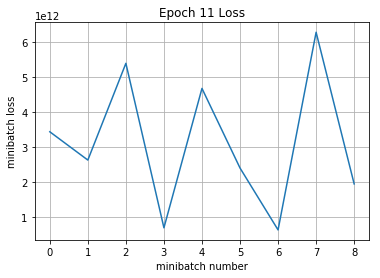

Iteration 100: with minibatch training loss = 1.28484810752e+11
Epoch 12, Overall loss = 1.53684035356e+11
Iteration 110: with minibatch training loss = 2.64027029504e+11
Epoch 13, Overall loss = 1.51838184562e+11
Iteration 120: with minibatch training loss = 34009284608.0
Epoch 14, Overall loss = 1.50158067484e+11
Iteration 130: with minibatch training loss = 2.20478455808e+11
Epoch 15, Overall loss = 1.48646585003e+11
Iteration 140: with minibatch training loss = 1.13240203264e+11
Epoch 16, Overall loss = 1.47300067556e+11
Iteration 150: with minibatch training loss = 30144419840.0
Epoch 17, Overall loss = 1.46014986695e+11
Iteration 160: with minibatch training loss = 2.98740482048e+11
Epoch 18, Overall loss = 1.44809415339e+11
Iteration 170: with minibatch training loss = 86993534976.0
Epoch 19, Overall loss = 1.43724812516e+11
Epoch 20, Overall loss = 1.42739417771e+11
Iteration 180: with minibatch training loss = 1.5234048e+11
Epoch 21, Overall loss = 1.41812111132e+11


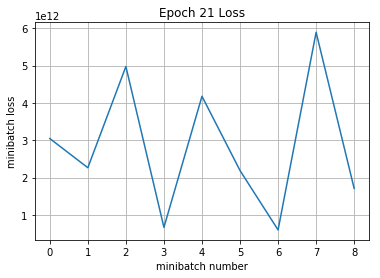

Iteration 190: with minibatch training loss = 1.12189243392e+11
Epoch 22, Overall loss = 1.40881796892e+11
Iteration 200: with minibatch training loss = 2.45844180992e+11
Epoch 23, Overall loss = 1.3997103013e+11
Iteration 210: with minibatch training loss = 32961060864.0
Epoch 24, Overall loss = 1.39092596053e+11
Iteration 220: with minibatch training loss = 2.03965612032e+11
Epoch 25, Overall loss = 1.38385292629e+11
Iteration 230: with minibatch training loss = 1.06681393152e+11
Epoch 26, Overall loss = 1.37603254955e+11
Iteration 240: with minibatch training loss = 29442934784.0
Epoch 27, Overall loss = 1.36684884196e+11
Iteration 250: with minibatch training loss = 2.8542844928e+11
Epoch 28, Overall loss = 1.35881726635e+11
Iteration 260: with minibatch training loss = 80540852224.0
Epoch 29, Overall loss = 1.35179476309e+11
Epoch 30, Overall loss = 1.34498158592e+11
Iteration 270: with minibatch training loss = 1.41314392064e+11
Epoch 31, Overall loss = 1.33818986724e+11


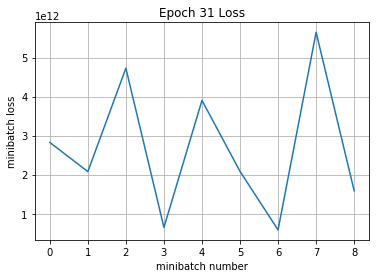

Iteration 280: with minibatch training loss = 1.030203392e+11
Epoch 32, Overall loss = 1.33164795449e+11
Iteration 290: with minibatch training loss = 2.33238986752e+11
Epoch 33, Overall loss = 1.32603674624e+11
Iteration 300: with minibatch training loss = 32220985344.0
Epoch 34, Overall loss = 1.32123955883e+11
Iteration 310: with minibatch training loss = 1.89943513088e+11
Epoch 35, Overall loss = 1.31392168164e+11
Iteration 320: with minibatch training loss = 1.02269124608e+11
Epoch 36, Overall loss = 1.30646958308e+11
Iteration 330: with minibatch training loss = 29199370240.0
Epoch 37, Overall loss = 1.30081784036e+11
Iteration 340: with minibatch training loss = 2.77588279296e+11
Epoch 38, Overall loss = 1.29522664789e+11
Iteration 350: with minibatch training loss = 75576377344.0
Epoch 39, Overall loss = 1.2892069888e+11
Epoch 40, Overall loss = 1.28292931356e+11
Iteration 360: with minibatch training loss = 1.33847400448e+11
Epoch 41, Overall loss = 1.27737152853e+11


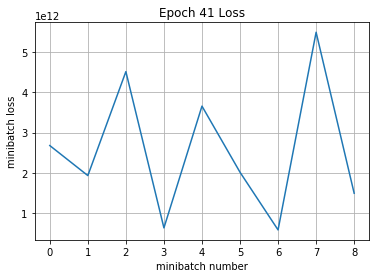

Iteration 370: with minibatch training loss = 95892955136.0
Epoch 42, Overall loss = 1.27207849301e+11
Iteration 380: with minibatch training loss = 2.23827001344e+11
Epoch 43, Overall loss = 1.26726761358e+11
Iteration 390: with minibatch training loss = 31896051712.0
Epoch 44, Overall loss = 1.26331100956e+11
Iteration 400: with minibatch training loss = 1.78544214016e+11
Epoch 45, Overall loss = 1.25874999751e+11
Iteration 410: with minibatch training loss = 99611795456.0
Epoch 46, Overall loss = 1.2544146523e+11
Iteration 420: with minibatch training loss = 29830062080.0
Epoch 47, Overall loss = 1.24974715108e+11
Iteration 430: with minibatch training loss = 2.70525120512e+11
Epoch 48, Overall loss = 1.24616122823e+11
Iteration 440: with minibatch training loss = 72032796672.0
Epoch 49, Overall loss = 1.24239398457e+11
Epoch 50, Overall loss = 1.23784909255e+11
Iteration 450: with minibatch training loss = 1.29497776128e+11
Epoch 51, Overall loss = 1.23301250389e+11


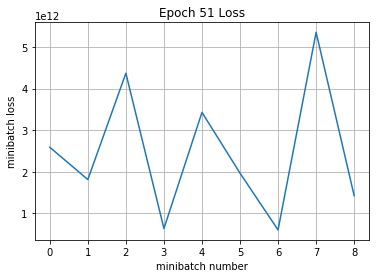

Iteration 460: with minibatch training loss = 90132946944.0
Epoch 52, Overall loss = 1.22952747236e+11
Iteration 470: with minibatch training loss = 2.172817408e+11
Epoch 53, Overall loss = 1.22570567225e+11
Iteration 480: with minibatch training loss = 31956457472.0
Epoch 54, Overall loss = 1.221240543e+11
Iteration 490: with minibatch training loss = 1.67544389632e+11
Epoch 55, Overall loss = 1.21803329308e+11
Iteration 500: with minibatch training loss = 97726201856.0
Epoch 56, Overall loss = 1.21446003826e+11
Iteration 510: with minibatch training loss = 30861242368.0
Epoch 57, Overall loss = 1.20940924018e+11
Iteration 520: with minibatch training loss = 2.64123973632e+11
Epoch 58, Overall loss = 1.20505570418e+11
Iteration 530: with minibatch training loss = 69134548992.0
Epoch 59, Overall loss = 1.20117427769e+11
Epoch 60, Overall loss = 1.19795113756e+11
Iteration 540: with minibatch training loss = 1.24592422912e+11
Epoch 61, Overall loss = 1.1943231306e+11


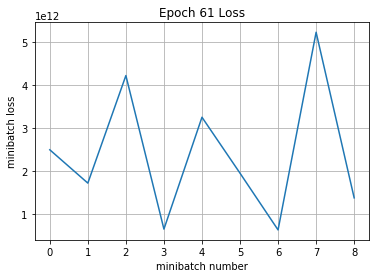

Iteration 550: with minibatch training loss = 85289287680.0
Epoch 62, Overall loss = 1.191778081e+11
Iteration 560: with minibatch training loss = 2.09723490304e+11
Epoch 63, Overall loss = 1.18793148644e+11
Iteration 570: with minibatch training loss = 32487858176.0
Epoch 64, Overall loss = 1.18671282859e+11
Iteration 580: with minibatch training loss = 1.59870386176e+11
Epoch 65, Overall loss = 1.18450171221e+11
Iteration 590: with minibatch training loss = 96936624128.0
Epoch 66, Overall loss = 1.18418633614e+11
Iteration 600: with minibatch training loss = 31861231616.0
Epoch 67, Overall loss = 1.18138291541e+11
Iteration 610: with minibatch training loss = 2.60885446656e+11
Epoch 68, Overall loss = 1.1814795082e+11
Iteration 620: with minibatch training loss = 67084800000.0
Epoch 69, Overall loss = 1.17829474532e+11
Epoch 70, Overall loss = 1.17399525604e+11
Iteration 630: with minibatch training loss = 1.22052108288e+11
Epoch 71, Overall loss = 1.16926119481e+11


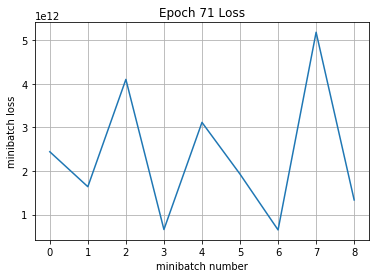

Iteration 640: with minibatch training loss = 81424343040.0
Epoch 72, Overall loss = 1.1675944118e+11
Iteration 650: with minibatch training loss = 2.04152471552e+11
Epoch 73, Overall loss = 1.16569315783e+11
Iteration 660: with minibatch training loss = 32986611712.0
Epoch 74, Overall loss = 1.16386669454e+11
Iteration 670: with minibatch training loss = 1.5344197632e+11
Epoch 75, Overall loss = 1.16074393372e+11
Iteration 680: with minibatch training loss = 95998779392.0
Epoch 76, Overall loss = 1.15705802297e+11
Iteration 690: with minibatch training loss = 32881926144.0
Epoch 77, Overall loss = 1.15412148907e+11
Iteration 700: with minibatch training loss = 2.53972824064e+11
Epoch 78, Overall loss = 1.1524360101e+11
Iteration 710: with minibatch training loss = 65481093120.0
Epoch 79, Overall loss = 1.14957908651e+11
Epoch 80, Overall loss = 1.14646082901e+11
Iteration 720: with minibatch training loss = 1.19135543296e+11
Epoch 81, Overall loss = 1.14316747207e+11


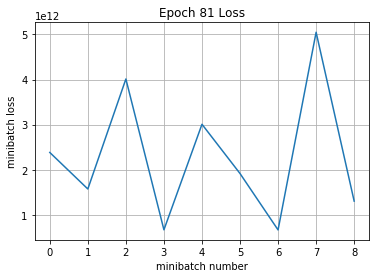

Iteration 730: with minibatch training loss = 78278893568.0
Epoch 82, Overall loss = 1.14084908828e+11
Iteration 740: with minibatch training loss = 1.99284670464e+11
Epoch 83, Overall loss = 1.13950237582e+11
Iteration 750: with minibatch training loss = 33530533888.0
Epoch 84, Overall loss = 1.13941094172e+11
Iteration 760: with minibatch training loss = 1.48314652672e+11
Epoch 85, Overall loss = 1.13775628971e+11
Iteration 770: with minibatch training loss = 95645917184.0
Epoch 86, Overall loss = 1.13450501461e+11
Iteration 780: with minibatch training loss = 33794260992.0
Epoch 87, Overall loss = 1.13126023168e+11
Iteration 790: with minibatch training loss = 2.50139672576e+11
Epoch 88, Overall loss = 1.12950914617e+11
Iteration 800: with minibatch training loss = 64272310272.0
Epoch 89, Overall loss = 1.12770617572e+11
Epoch 90, Overall loss = 1.1269232549e+11
Iteration 810: with minibatch training loss = 1.17489057792e+11
Epoch 91, Overall loss = 1.12561300366e+11


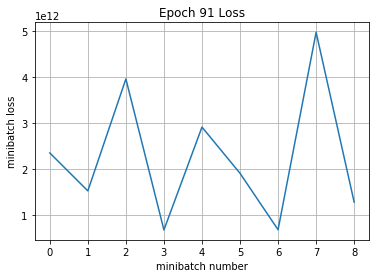

Iteration 820: with minibatch training loss = 75916615680.0
Epoch 92, Overall loss = 1.12486429355e+11
Iteration 830: with minibatch training loss = 1.96371136512e+11
Epoch 93, Overall loss = 1.12232406812e+11
Iteration 840: with minibatch training loss = 34033731584.0
Epoch 94, Overall loss = 1.12233535716e+11
Iteration 850: with minibatch training loss = 1.44048996352e+11
Epoch 95, Overall loss = 1.12408112469e+11
Iteration 860: with minibatch training loss = 96206528512.0
Epoch 96, Overall loss = 1.12746979556e+11
Iteration 870: with minibatch training loss = 34519101440.0
Epoch 97, Overall loss = 1.12699202901e+11
Iteration 880: with minibatch training loss = 2.55602753536e+11
Epoch 98, Overall loss = 1.12618834603e+11
Iteration 890: with minibatch training loss = 63040282624.0
Epoch 99, Overall loss = 1.12123072057e+11
Epoch 100, Overall loss = 1.11631773241e+11
Iteration 900: with minibatch training loss = 1.17595766784e+11
Epoch 101, Overall loss = 1.11169914197e+11


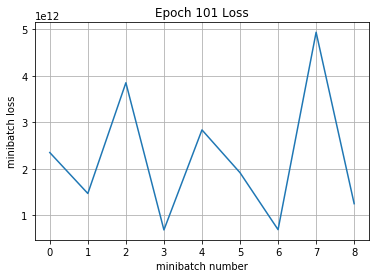

Iteration 910: with minibatch training loss = 73124364288.0
Epoch 102, Overall loss = 1.11022911943e+11
Iteration 920: with minibatch training loss = 1.91471845376e+11
Epoch 103, Overall loss = 1.10661037625e+11
Iteration 930: with minibatch training loss = 34555105280.0
Epoch 104, Overall loss = 1.10594948665e+11
Iteration 940: with minibatch training loss = 1.42032945152e+11
Epoch 105, Overall loss = 1.10403608121e+11
Iteration 950: with minibatch training loss = 95358050304.0
Epoch 106, Overall loss = 1.10486428786e+11
Iteration 960: with minibatch training loss = 35123724288.0
Epoch 107, Overall loss = 1.10271934464e+11
Iteration 970: with minibatch training loss = 2.44402896896e+11
Epoch 108, Overall loss = 1.10415137451e+11
Iteration 980: with minibatch training loss = 61928636416.0
Epoch 109, Overall loss = 1.1020722176e+11
Epoch 110, Overall loss = 1.10066482745e+11
Iteration 990: with minibatch training loss = 1.15398524928e+11
Epoch 111, Overall loss = 1.09522076103e+11


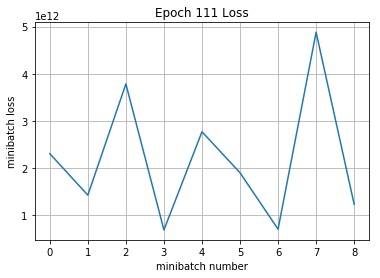

Iteration 1000: with minibatch training loss = 70925549568.0
Epoch 112, Overall loss = 1.09330672299e+11
Iteration 1010: with minibatch training loss = 1.88451192832e+11
Epoch 113, Overall loss = 1.08963726222e+11
Iteration 1020: with minibatch training loss = 34784378880.0
Epoch 114, Overall loss = 1.08866666951e+11
Iteration 1030: with minibatch training loss = 1.37001689088e+11
Epoch 115, Overall loss = 1.08597500587e+11
Iteration 1040: with minibatch training loss = 94896308224.0
Epoch 116, Overall loss = 1.08547377835e+11
Iteration 1050: with minibatch training loss = 35599360000.0
Epoch 117, Overall loss = 1.08342561451e+11
Iteration 1060: with minibatch training loss = 2.40568696832e+11
Epoch 118, Overall loss = 1.08301799424e+11
Iteration 1070: with minibatch training loss = 60967981056.0
Epoch 119, Overall loss = 1.08070137401e+11
Epoch 120, Overall loss = 1.08000799403e+11
Iteration 1080: with minibatch training loss = 1.13301929984e+11
Epoch 121, Overall loss = 1.07843088839

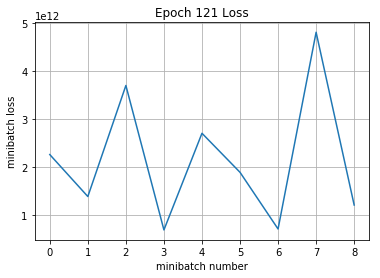

Iteration 1090: with minibatch training loss = 69308473344.0
Epoch 122, Overall loss = 1.07866289493e+11
Iteration 1100: with minibatch training loss = 1.84303058944e+11
Epoch 123, Overall loss = 1.07601932288e+11
Iteration 1110: with minibatch training loss = 35058536448.0
Epoch 124, Overall loss = 1.07463623111e+11
Iteration 1120: with minibatch training loss = 1.34093832192e+11
Epoch 125, Overall loss = 1.07244411108e+11
Iteration 1130: with minibatch training loss = 95091556352.0
Epoch 126, Overall loss = 1.07370372665e+11
Iteration 1140: with minibatch training loss = 36159021056.0
Epoch 127, Overall loss = 1.07368462564e+11
Iteration 1150: with minibatch training loss = 2.4310325248e+11
Epoch 128, Overall loss = 1.07491758535e+11
Iteration 1160: with minibatch training loss = 60122046464.0
Epoch 129, Overall loss = 1.07229871218e+11
Epoch 130, Overall loss = 1.0705479589e+11
Iteration 1170: with minibatch training loss = 1.136494592e+11
Epoch 131, Overall loss = 1.06770629518e+11

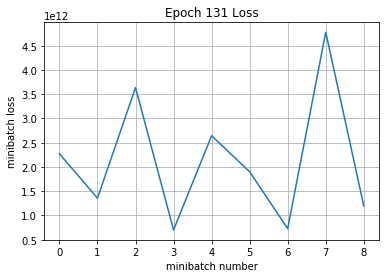

Iteration 1180: with minibatch training loss = 67476512768.0
Epoch 132, Overall loss = 1.06842828345e+11
Iteration 1190: with minibatch training loss = 1.81304721408e+11
Epoch 133, Overall loss = 1.06741342663e+11
Iteration 1200: with minibatch training loss = 35416887296.0
Epoch 134, Overall loss = 1.06898682766e+11
Iteration 1210: with minibatch training loss = 1.31280896e+11
Epoch 135, Overall loss = 1.06923686571e+11
Iteration 1220: with minibatch training loss = 95392120832.0
Epoch 136, Overall loss = 1.07671605248e+11
Iteration 1230: with minibatch training loss = 36776960000.0
Epoch 137, Overall loss = 1.08000453063e+11
Iteration 1240: with minibatch training loss = 2.51477426176e+11
Epoch 138, Overall loss = 1.08059242951e+11
Iteration 1250: with minibatch training loss = 59528331264.0
Epoch 139, Overall loss = 1.07265296156e+11
Epoch 140, Overall loss = 1.0648702794e+11
Iteration 1260: with minibatch training loss = 1.11910150144e+11
Epoch 141, Overall loss = 1.05687632555e+11

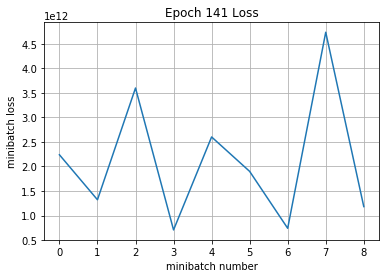

Iteration 1270: with minibatch training loss = 65630384128.0
Epoch 142, Overall loss = 1.05564665628e+11
Iteration 1280: with minibatch training loss = 1.78388795392e+11
Epoch 143, Overall loss = 1.05351308629e+11
Iteration 1290: with minibatch training loss = 35585449984.0
Epoch 144, Overall loss = 1.05391605988e+11
Iteration 1300: with minibatch training loss = 1.295214592e+11
Epoch 145, Overall loss = 1.05240509554e+11
Iteration 1310: with minibatch training loss = 95234850816.0
Epoch 146, Overall loss = 1.05310400967e+11
Iteration 1320: with minibatch training loss = 37145530368.0
Epoch 147, Overall loss = 1.05149453653e+11
Iteration 1330: with minibatch training loss = 2.33839755264e+11
Epoch 148, Overall loss = 1.05139336533e+11
Iteration 1340: with minibatch training loss = 58676408320.0
Epoch 149, Overall loss = 1.04894311083e+11
Epoch 150, Overall loss = 1.04775731428e+11
Iteration 1350: with minibatch training loss = 1.11775055872e+11
Epoch 151, Overall loss = 1.04477396537e+

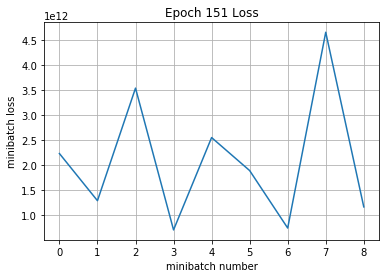

Iteration 1360: with minibatch training loss = 64379273216.0
Epoch 152, Overall loss = 1.04429592121e+11
Iteration 1370: with minibatch training loss = 1.76363962368e+11
Epoch 153, Overall loss = 1.04216224199e+11
Iteration 1380: with minibatch training loss = 35667705856.0
Epoch 154, Overall loss = 1.04184111104e+11
Iteration 1390: with minibatch training loss = 1.26648172544e+11
Epoch 155, Overall loss = 1.04069482724e+11
Iteration 1400: with minibatch training loss = 94994186240.0
Epoch 156, Overall loss = 1.04075794204e+11
Iteration 1410: with minibatch training loss = 37549023232.0
Epoch 157, Overall loss = 1.03866949632e+11
Iteration 1420: with minibatch training loss = 2.31608614912e+11
Epoch 158, Overall loss = 1.038626816e+11
Iteration 1430: with minibatch training loss = 58051448832.0
Epoch 159, Overall loss = 1.03711528277e+11
Epoch 160, Overall loss = 1.0373975882e+11
Iteration 1440: with minibatch training loss = 1.10104035328e+11
Epoch 161, Overall loss = 1.0347247707e+11

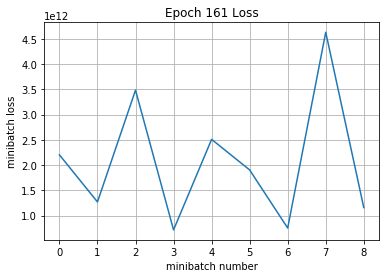

Iteration 1450: with minibatch training loss = 63171469312.0
Epoch 162, Overall loss = 1.03515369472e+11
Iteration 1460: with minibatch training loss = 1.74766292992e+11
Epoch 163, Overall loss = 1.03437213241e+11
Iteration 1470: with minibatch training loss = 36420689920.0
Epoch 164, Overall loss = 1.03686121244e+11
Iteration 1480: with minibatch training loss = 1.24955344896e+11
Epoch 165, Overall loss = 1.03452205056e+11
Iteration 1490: with minibatch training loss = 97238474752.0
Epoch 166, Overall loss = 1.03507159723e+11
Iteration 1500: with minibatch training loss = 38102970368.0
Epoch 167, Overall loss = 1.03090414478e+11
Iteration 1510: with minibatch training loss = 2.29703417856e+11
Epoch 168, Overall loss = 1.03119371833e+11
Iteration 1520: with minibatch training loss = 57521983488.0
Epoch 169, Overall loss = 1.02730792505e+11
Epoch 170, Overall loss = 1.02823600128e+11
Iteration 1530: with minibatch training loss = 1.09513048064e+11
Epoch 171, Overall loss = 1.02575052572

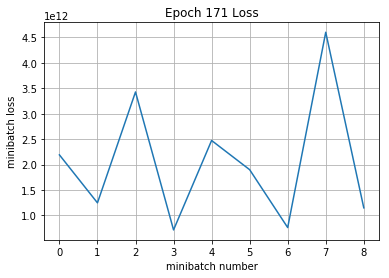

Iteration 1540: with minibatch training loss = 62129676288.0
Epoch 172, Overall loss = 1.02693454734e+11
Iteration 1550: with minibatch training loss = 1.7246978048e+11
Epoch 173, Overall loss = 1.02602177195e+11
Iteration 1560: with minibatch training loss = 36100136960.0
Epoch 174, Overall loss = 1.02965637575e+11
Iteration 1570: with minibatch training loss = 1.2313296896e+11
Epoch 175, Overall loss = 1.02872019854e+11
Iteration 1580: with minibatch training loss = 95152922624.0
Epoch 176, Overall loss = 1.02940290617e+11
Iteration 1590: with minibatch training loss = 38417801216.0
Epoch 177, Overall loss = 1.02490651762e+11
Iteration 1600: with minibatch training loss = 2.29859426304e+11
Epoch 178, Overall loss = 1.02380429312e+11
Iteration 1610: with minibatch training loss = 56858292224.0
Epoch 179, Overall loss = 1.02188861668e+11
Epoch 180, Overall loss = 1.02314789092e+11
Iteration 1620: with minibatch training loss = 1.1293945856e+11
Epoch 181, Overall loss = 1.02231808683e+1

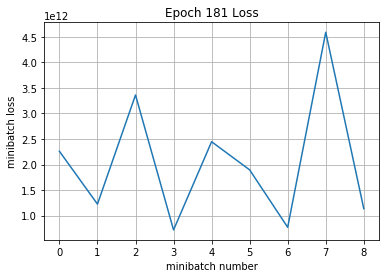

Iteration 1630: with minibatch training loss = 60920012800.0
Epoch 182, Overall loss = 1.02054615268e+11
Iteration 1640: with minibatch training loss = 1.67721582592e+11
Epoch 183, Overall loss = 1.01636160626e+11
Iteration 1650: with minibatch training loss = 36103335936.0
Epoch 184, Overall loss = 1.01614615211e+11
Iteration 1660: with minibatch training loss = 1.2141617152e+11
Epoch 185, Overall loss = 1.01887885312e+11
Iteration 1670: with minibatch training loss = 95075844096.0
Epoch 186, Overall loss = 1.02796015388e+11
Iteration 1680: with minibatch training loss = 38825070592.0
Epoch 187, Overall loss = 1.03438223132e+11
Iteration 1690: with minibatch training loss = 2.39315124224e+11
Epoch 188, Overall loss = 1.0318794661e+11
Iteration 1700: with minibatch training loss = 56406433792.0
Epoch 189, Overall loss = 1.02059844494e+11
Epoch 190, Overall loss = 1.01468178204e+11
Iteration 1710: with minibatch training loss = 1.11594676224e+11
Epoch 191, Overall loss = 1.0104612682e+1

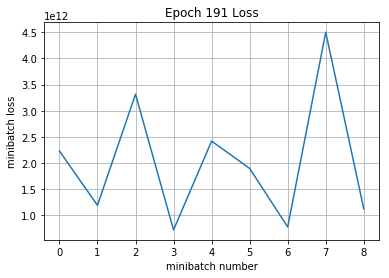

Iteration 1720: with minibatch training loss = 59220811776.0
Epoch 192, Overall loss = 1.00751742748e+11
Iteration 1730: with minibatch training loss = 1.65069357056e+11
Epoch 193, Overall loss = 1.0044788827e+11
Iteration 1740: with minibatch training loss = 36184068096.0
Epoch 194, Overall loss = 1.00333053269e+11
Iteration 1750: with minibatch training loss = 1.19543226368e+11
Epoch 195, Overall loss = 1.00224725447e+11
Iteration 1760: with minibatch training loss = 94766964736.0
Epoch 196, Overall loss = 1.00180454514e+11
Iteration 1770: with minibatch training loss = 39216095232.0
Epoch 197, Overall loss = 1.00082277945e+11
Iteration 1780: with minibatch training loss = 2.23375147008e+11
Epoch 198, Overall loss = 1.00036739982e+11
Iteration 1790: with minibatch training loss = 56038064128.0
Epoch 199, Overall loss = 99871057237.3
Epoch 200, Overall loss = 99794141184.0
Validation
Epoch 1, Overall loss = 1.44866639872e+11
0
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


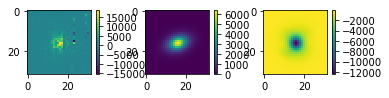

1
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


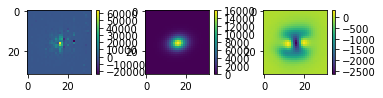

2
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


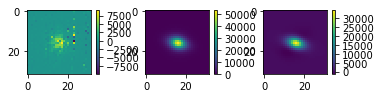

3
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


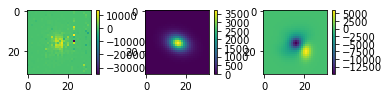

4
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


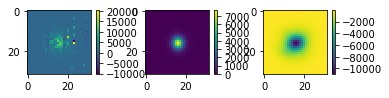

In [94]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 2])
y = tf.placeholder(tf.float32, [None, 32, 32])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 2, 256])
    bconv1 = tf.get_variable("bconv1", shape=[256])
    W1 = tf.get_variable("W1", shape=[32,32,1,49])
    b1 = tf.get_variable("b1", shape=[32,32])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[32,32, 49, -1])
    y_out = tf.matmul(W1,h1_flat) #+ b1
    y_out = tf.transpose(y_out)
    y_out= tf.reshape(y_out, [-1,32,32])
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.nn.l2_loss(y - y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(1e-3) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)


def run_model(session, predict, mean_loss, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    pred_loss = tf.reduce_mean((tf.nn.l2_loss(y - predict)))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, pred_loss,]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:, :, :],
                         y: yd[idx, :, :],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, im = session.run(variables,feed_dict=feed_dict)
            pred = y_out.eval(session=session, feed_dict=feed_dict)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1}"\
                      .format(iter_cnt,loss))
            iter_cnt += 1
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0}"\
              .format(total_loss, e+1))
        if plot_losses and (e % print_every) == 0:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
        if training_now is False:
            for num in range(5):
                print  num
                plt.subplot(3,3,1)
                print pred.shape, yd.shape
                plt.imshow(pred[num])
                plt.colorbar()
                plt.subplot(3,3,2)
                plt.imshow(yd[num])
                plt.colorbar()
                plt.subplot(3,3,3)
                print Xd.shape
                plt.imshow(Xd[num, :, :,0])
                plt.colorbar()
                plt.show()
    return total_loss

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,Y_train,200,20,10,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,Y_val,1,20)

In [90]:
im=np.mean(X_train, axis=0)
im.shape

(32, 32, 2)

In [88]:
im

-2.9684896516199743e-14